In [ ]:
## Overview
This notebook explores global tuberculosis treatment success trends using WHO surveillance data, with a focus on identifying hidden stagnation and reporting instability at the country level.


In [ ]:
#Importing packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [ ]:
# Loading datasets
main_file = "/content/TB_outcomes_2025-12-13.csv"
age_sex_file = "/content/TB_outcomes_age_sex_2025-12-13.csv"

tb = pd.read_csv(main_file)
tb_age = pd.read_csv(age_sex_file)

# Standardize column names
tb.columns = tb.columns.str.lower()
tb_age.columns = tb_age.columns.str.lower()

tb.head(), tb_age.head()


(       country iso2 iso3  iso_numeric g_whoregion  year  rep_meth  new_sp_coh  \
 0  Afghanistan   AF  AFG            4         EMR  1994       NaN         NaN   
 1  Afghanistan   AF  AFG            4         EMR  1995       NaN         NaN   
 2  Afghanistan   AF  AFG            4         EMR  1996       NaN         NaN   
 3  Afghanistan   AF  AFG            4         EMR  1997     100.0      2001.0   
 4  Afghanistan   AF  AFG            4         EMR  1998     100.0      2913.0   
 
    new_sp_cur  new_sp_cmplt  ...  mdr_coh  mdr_succ  mdr_fail  mdr_died  \
 0         NaN           NaN  ...      NaN       NaN       NaN       NaN   
 1         NaN           NaN  ...      NaN       NaN       NaN       NaN   
 2         NaN           NaN  ...      NaN       NaN       NaN       NaN   
 3       786.0         108.0  ...      NaN       NaN       NaN       NaN   
 4       772.0         199.0  ...      NaN       NaN       NaN       NaN   
 
    mdr_lost  xdr_coh  xdr_succ  xdr_fail  xdr_d

In [ ]:
# Keep only rows with valid TSR
tb_core = tb.dropna(subset=["c_new_tsr"]).copy()

tb_core["year"] = tb_core["year"].astype(int)

tb_core[["country", "year", "c_new_tsr"]].head()


,country,year,c_new_tsr
3,Afghanistan,1997,45.0
4,Afghanistan,1998,33.0
5,Afghanistan,1999,86.0
6,Afghanistan,2000,85.0
7,Afghanistan,2001,84.0


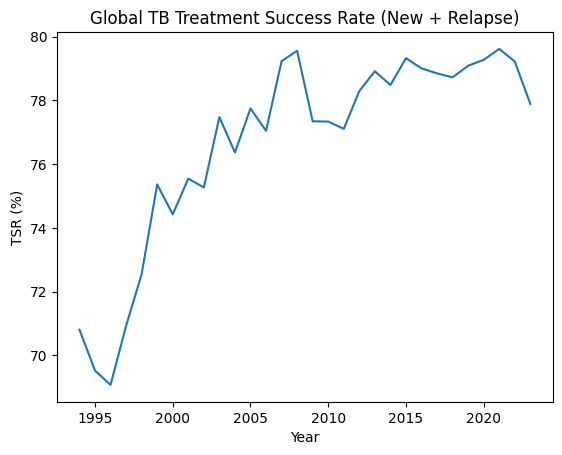

In [ ]:
#Global success trends
global_trend = tb_core.groupby("year")["c_new_tsr"].mean()

plt.figure()
global_trend.plot()
plt.title("Global TB Treatment Success Rate (New + Relapse)")
plt.ylabel("TSR (%)")
plt.xlabel("Year")
plt.show()


In [ ]:
country_year = (
    tb_core
    .groupby(["country", "year"])["c_new_tsr"]
    .mean()
    .reset_index()
)

slopes = []

for country in country_year["country"].unique():
    df = country_year[country_year["country"] == country]
    if len(df) >= 5:  # minimum years
        slope = np.polyfit(df["year"], df["c_new_tsr"], 1)[0]
        slopes.append((country, slope))

slopes_df = pd.DataFrame(slopes, columns=["country", "trend_slope"])

# Countries with worst trends
slopes_df.sort_values("trend_slope").head(10)


,country,trend_slope
108,Luxembourg,-3.575120
55,Denmark,-3.162174
202,Wallis and Futuna,-2.307985
90,Ireland,-2.301538
129,New Caledonia,-2.196970
23,Bosnia and Herzegovina,-1.991324
68,Finland,-1.887255
178,Switzerland,-1.785714
137,Oman,-1.609852
173,Spain,-1.450103


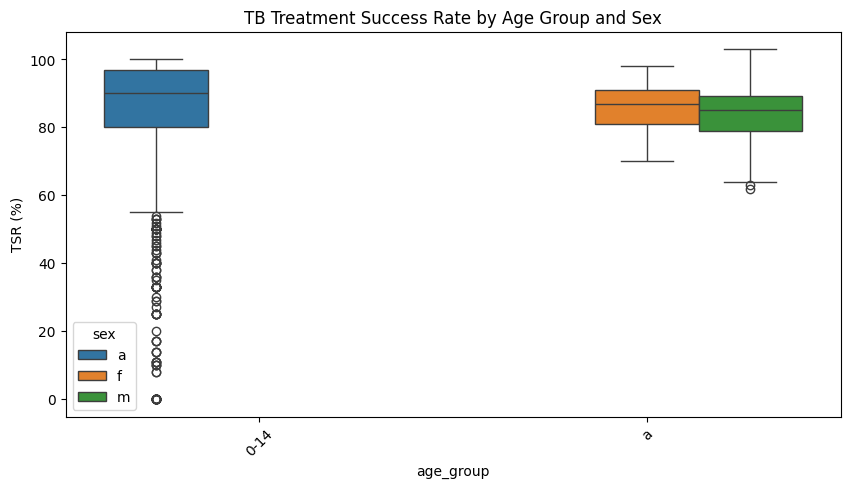

In [ ]:
tb_age_clean = tb_age.dropna(subset=["tsr"]).copy()
tb_age_clean["year"] = tb_age_clean["year"].astype(int)

plt.figure(figsize=(10,5))
sns.boxplot(
    data=tb_age_clean,
    x="age_group",
    y="tsr",
    hue="sex"
)
plt.title("TB Treatment Success Rate by Age Group and Sex")
plt.xticks(rotation=45)
plt.ylabel("TSR (%)")
plt.show()


In [ ]:
model_df = country_year.copy()

X = model_df[["year"]]
y = model_df["c_new_tsr"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mae


11.74399887521446

In [ ]:
#Uncertainty as key information
model_df["predicted"] = model.predict(model_df[["year"]])
model_df["error"] = abs(model_df["c_new_tsr"] - model_df["predicted"])

error_by_country = (
    model_df.groupby("country")["error"]
    .mean()
    .reset_index()
    .sort_values("error", ascending=False)
)

error_by_country.head(10)


,country,error
78,Greece,79.241976
135,Netherlands Antilles,74.625853
51,Curaçao,61.207569
124,Monaco,60.003776
71,France,50.626653
166,San Marino,50.384677
112,Luxembourg,49.823596
10,Aruba,46.243549
70,Finland,44.354975
28,British Virgin Islands,43.843863


In [ ]:
combined = slopes_df.merge(error_by_country, on="country")

combined.sort_values(
    ["trend_slope", "error"],
    ascending=[True, False]
).head(10)


,country,trend_slope,error
108,Luxembourg,-3.575120,49.823596
55,Denmark,-3.162174,23.725012
202,Wallis and Futuna,-2.307985,25.763415
90,Ireland,-2.301538,25.385648
129,New Caledonia,-2.196970,21.776880
23,Bosnia and Herzegovina,-1.991324,21.810903
68,Finland,-1.887255,44.354975
178,Switzerland,-1.785714,9.316159
137,Oman,-1.609852,20.170446
173,Spain,-1.450103,17.963812


In [ ]:
print("""
LIMITATIONS:
- Ecological (country-level) analysis
- No individual patient data
- No causal inference
- Reporting quality varies across countries
- TSR reflects programmatic outcomes, not biological response
""")



LIMITATIONS:
- Ecological (country-level) analysis
- No individual patient data
- No causal inference
- Reporting quality varies across countries
- TSR reflects programmatic outcomes, not biological response

